In [338]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pandas_ta as ta
import yfinance as yf

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

import datetime

In [339]:
def get_data(ticker, start, end):
    data =  yf.download(ticker, progress=True, actions=True,start=start, end=end)
    data = pd.DataFrame(data)
    data.rename(columns = {'Adj Close':ticker}, inplace=True)
    data.drop(['Close', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
    data.dropna(inplace=True)
    
    return data

In [340]:
ticker =  'GOOG'

In [341]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2022, 12, 31)

traindf = get_data(ticker, start, end)

[*********************100%%**********************]  1 of 1 completed


In [342]:
start_test = datetime.datetime(2023, 1, 1)
end_test = datetime.datetime(2023, 12, 31)

testdf = get_data(ticker, start_test, end_test)

[*********************100%%**********************]  1 of 1 completed


In [343]:
train_dates = traindf.index
test_dates = testdf.index

In [344]:
sc = MinMaxScaler(feature_range=(0,1))

In [345]:
def feature_extraction(data):
    for leng in [10,20,30]:
            sma = ta.sma(data[ticker], length=leng)
            data['SMA_'+f'{leng}'] = sma

    data['RSI_14'] = ta.rsi(data[ticker], length=14)
    stoch = ta.stoch(data['High'], data['Low'], data[ticker])
    stochk = stoch['STOCHk_14_3_3']
    data = data[13:]
    data['Stoch_Oscillator'] = stochk

    williams_r = ta.willr(data['High'], data['Low'], data[ticker])
    data['Williams_%R'] = williams_r

    adx = ta.adx(data['High'], data['Low'], data[ticker])
    data['ADX'] = adx['ADX_14']

    data['returns'] = np.log(data[ticker] / data[ticker].shift(1))
    data.dropna(inplace=True)
    data['direction'] = [1 if data.returns[i]>0 else 0 for i in range(len(data))]
    features = [col for col in data.columns if col not in [ticker, 'returns', 'Open', 'High', 'Low', 'Volume']]

    return data[features].dropna(axis=0)

In [346]:
train = np.array(feature_extraction(traindf))
test = np.array(feature_extraction(testdf))

train = sc.fit_transform(train)
test = sc.fit_transform(test)

/tmp/ipykernel_11211/36618539.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Stoch_Oscillator'] = stochk
/tmp/ipykernel_11211/36618539.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Williams_%R'] = williams_r
/tmp/ipykernel_11211/36618539.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

last element in each input is the target variable, append last element to Y

In [347]:
train[:10]

array([[0.00814292, 0.00713607, 0.00499457, 0.53998241, 0.86042771,
        0.88201577, 0.40015488, 1.        ],
       [0.008415  , 0.00747255, 0.00487998, 0.52268958, 0.82781729,
        0.84090029, 0.42809586, 0.        ],
       [0.0085925 , 0.0076394 , 0.00505674, 0.42379826, 0.77859182,
        0.590633  , 0.39732219, 0.        ],
       [0.00842553, 0.00760095, 0.00517834, 0.31528116, 0.59844845,
        0.34902707, 0.37086396, 0.        ],
       [0.00840447, 0.00760123, 0.00534016, 0.33943178, 0.45172107,
        0.40677921, 0.33836709, 1.        ],
       [0.0084235 , 0.00757599, 0.00557566, 0.34407618, 0.3931883 ,
        0.41745256, 0.30853047, 1.        ],
       [0.00824525, 0.00747162, 0.00577676, 0.26621925, 0.34322257,
        0.20119389, 0.30112708, 0.        ],
       [0.00816841, 0.00746455, 0.0059342 , 0.33568933, 0.32571864,
        0.35499049, 0.29661247, 1.        ],
       [0.00815714, 0.0075165 , 0.00618496, 0.48232293, 0.43859241,
        0.75141123, 0.252447

In [348]:
look_back = 32
num_features = len(train[0])
num_features

8

We want the first i-1 inputs without the last feature(direction) in X and the ith inputs last input(direction) in y 

In [349]:
def preprocess_data(dataset,step):
    X = []
    Y = []
    for i in range(step, len(dataset)):
        X.append([arr[:num_features] for arr in dataset[i-step:i]])
        Y.append(dataset[i][len(dataset[i])-1])

    X, Y = np.array(X), np.array(Y)
    X = np.reshape(X, (X.shape[0], X.shape[1], num_features))
    return X, Y

In [350]:
X_train, y_train = preprocess_data(train,look_back)
X_test, y_test = preprocess_data(test, look_back)

In [351]:
model = Sequential()
model.add(LSTM(units=100,return_sequences=True,batch_input_shape=(32, look_back, num_features)))
model.add(Dropout(0.1))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

impl = model.fit(
    X_train,
    y_train,
    epochs=100
    )

Epoch 1/100
85/85 [==============================] - 7s 42ms/step - loss: 0.6943 - accuracy: 0.5145
Epoch 2/100
85/85 [==============================] - 4s 41ms/step - loss: 0.6923 - accuracy: 0.5274
Epoch 3/100
85/85 [==============================] - 3s 35ms/step - loss: 0.6924 - accuracy: 0.5245
Epoch 4/100
85/85 [==============================] - 3s 35ms/step - loss: 0.6923 - accuracy: 0.5274
Epoch 5/100
85/85 [==============================] - 3s 36ms/step - loss: 0.6921 - accuracy: 0.5274
Epoch 6/100
85/85 [==============================] - 3s 36ms/step - loss: 0.6923 - accuracy: 0.5274
Epoch 7/100
85/85 [==============================] - 3s 36ms/step - loss: 0.6921 - accuracy: 0.5274
Epoch 8/100
85/85 [==============================] - 3s 35ms/step - loss: 0.6918 - accuracy: 0.5256
Epoch 9/100
85/85 [==============================] - 3s 34ms/step - loss: 0.6916 - accuracy: 0.5274
Epoch 10/100
85/85 [==============================] - 3s 39ms/step - loss: 0.6919 - accuracy: 0.5267

In [352]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (32, 32, 100)             43600     
                                                                 
 dropout_54 (Dropout)        (32, 32, 100)             0         
                                                                 
 lstm_60 (LSTM)              (32, 32, 100)             80400     
                                                                 
 dropout_55 (Dropout)        (32, 32, 100)             0         
                                                                 
 lstm_61 (LSTM)              (32, 32, 100)             80400     
                                                                 
 dropout_56 (Dropout)        (32, 32, 100)             0         
                                                                 
 lstm_62 (LSTM)              (32, 100)               

In [353]:
y_pred = model.predict(X_test)
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred]

6/6 [==============================] - 1s 15ms/step


In [354]:
y_pred

[0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1]

In [355]:
y_test

array([0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0.])

In [356]:
target_names = ['direction_up', 'direction_down']

def measure_classification():
    print(f'====== {model} Classification report ======')
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=[1, 0]))

In [357]:
measure_classification()

====== <keras.src.engine.sequential.Sequential object at 0x7b85f7b69f50> Classification report ======
                precision    recall  f1-score   support

  direction_up       0.48      0.37      0.42        83
direction_down       0.54      0.65      0.59        95

      accuracy                           0.52       178
     macro avg       0.51      0.51      0.51       178
  weighted avg       0.52      0.52      0.51       178

[[62 33]
 [52 31]]


In [358]:
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)
testdf['y_pred'] = y_pred

array([[<Axes: title={'center': '0'}>]], dtype=object)

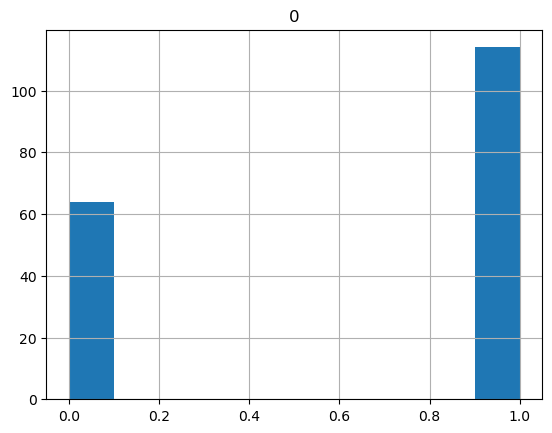

In [359]:
y_pred.hist()

array([[<Axes: title={'center': '0'}>]], dtype=object)

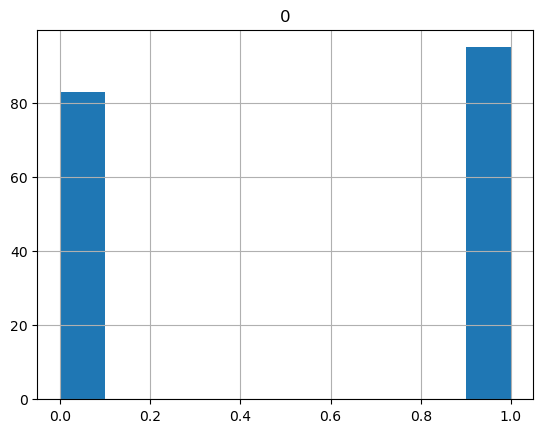

In [360]:
y_test.hist()